In [1]:
# import libraries
import os
from batchgenerators.utilities.file_and_folder_operations import *
import shutil
from nnunet.inference.predict import predict_cases, check_input_folder_and_return_caseIDs
from tqdm import tqdm
import SimpleITK as sitk
import numpy as np
from scipy.stats import entropy



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



In [2]:
from nnunet.preprocessing.cropping import crop_to_nonzero, load_case_from_list_of_files, crop_to_bbox

In [9]:
def bounding_box(img):
    """
    Calculated 3D bounding box of foreground pixel.
    
    Input: 3D numpy array where: 0 = background voxel
    Returns: slice object, that can be used like image[slice].
    Use for: Restrict performance evaluation on most relevant voxel.
    """
    # returns slices of the bounding box, enlarged by 2 units in each direction
    x = np.any(img, axis=(1,2))
    y = np.any(img, axis=(0,2))
    z = np.any(img, axis=(0,1))
    xmin, xmax = np.where(x)[0][[0, -1]]
    ymin, ymax = np.where(y)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]
    
    slices = np.s_[max(xmin, 2)-2: xmax+2, max(ymin, 5)-5: ymax+5, max(zmin, 5)-5: zmax+5]
    #print(img[np.ogrid[xmin:xmax, ymin:ymax, zmin:zmax]].shape)
    return slices#xmin, xmax, ymin, ymax, zmin, zmax


In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

In [407]:
normalizer = np.log2(4)

In [355]:
class trained_model:
    def __init__(self, optimizer, batch_size, specifier ,max_cycles, max_num_epochs, vendor=None):
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.specifier = specifier
        self.trainer_and_plan = "nnUNetTrainerV2_"+optimizer+"_fixedSchedule_Zhao2022"+specifier+"__nnUNetPlansv2.1_bs"+batch_size

        self.max_cycles = max_cycles
        self.max_num_epochs = max_num_epochs
        self.vendor = vendor
        
        self.max_num_epochs_per_cycle = int(self.max_num_epochs / self.max_cycles)
        self.save_last_x_checkpoints_per_cycle = 10
        
        self.set_checkpoint_lists()
        self.set_paths()
        self.set_vendor_keys()
        
        self.dice_best_model = None
        
    def set_checkpoint_lists(self):
        self.checkpoints_multi_modal = ["model_ep_%03.0d" % (epoch + 1) for epoch in range(self.max_num_epochs) if self.max_num_epochs_per_cycle - (epoch % self.max_num_epochs_per_cycle) <= self.save_last_x_checkpoints_per_cycle]
        self.checkpoints_single_modal = ["model_ep_%03.0d" % (epoch + 1) for epoch in range(self.max_num_epochs - self.save_last_x_checkpoints_per_cycle * self.max_cycles, self.max_num_epochs)]
        self.checkpoints_all = list(set(self.checkpoints_multi_modal + self.checkpoints_single_modal))

    def set_paths(self):
        # generate path where the test images, gt and (softmax and segm) predictions from the checkpoints
        # code base
        base = "/home/annalena/Seminar_Medical_Image_Analysis/code/"
        # raw test data
        raw_data_path = join(base, "data/nnUNet_raw_data_base/nnUNet_raw_data/")
        #preprocessed_data_path = join(base, "data/nnUNet_preprocessed/")
        self.folder_test_labels_raw = raw_data_path + "Task679_mnm/labelsTr/"
        self.folder_test_images_raw = raw_data_path + "Task679_mnm/imagesTr"
        #self.folder_test_labels_pp = preprocessed_data_path + "Task679_mnm/nnUNetData_plans_v2.1_2D_stage0/"
        #self.folder_test_images_pp = preprocessed_data_path + "Task679_mnm/gt_segmentations/"
        
        self.predictions_checkpoints_test = base + "nnUNet_trained_models/nnUNet/2d/Task500_ACDC/" + self.trainer_and_plan + "/prediction_Task679_mnm/"

        folder_with_predictions = join(self.predictions_checkpoints_test,"model_best")

        self.files_image = subfiles(self.folder_test_images_raw, suffix=".nii.gz", join=False)
        #files_pred = subfiles(folder_with_predictions, suffix=".nii.gz", join=False)
        self.files_pred_softmax = subfiles(folder_with_predictions, suffix=".npz", join=False)
        self.files_pred_segm = subfiles(folder_with_predictions, suffix=".nii.gz", join=False)
        
    ###
    
    def get_npz_name_from_no(self, case_no):
        return self.files_pred_softmax[case_no]
    
    def get_niigz_name_from_no(self, case_no):
        return self.files_pred_segm[case_no]
    
    def change_label_definition(gt, three_and_one = True):
        # The labelling conventions in the training and test set are different,
        # so the ground truth is adapted to the convention of the training set.
        # Function can/must be extended for other permutations.

        # change label 3 and label 1
        if three_and_one:
            gt[gt == 1] = 5
            gt[gt == 3] = 1
            gt[gt == 5] = 3

    def from_bbox_to_slice(b):
        xmin, xmax = b[0]
        ymin, ymax = b[1]
        zmin, zmax = b[2]
        slices = np.s_[max(xmin,0): xmax, max(ymin, 0): ymax, max(zmin, 0): zmax]
        return slices
    
    def get_cropping_bbox(self, case_no):
        input_path = join(self.folder_test_images_raw, self.files_image[case_no] )
        data, _, _ = load_case_from_list_of_files([input_path])
        _, _, bbox = crop_to_nonzero(data)
        return from_bbox_to_slice(bbox)
    
    def get_posterior_vector(self, case_no, multi_modal = True):

        case_name = self.get_npz_name_from_no(case_no)
        if multi_modal:
            all_epochs_one_prediction_paths = [join(self.predictions_checkpoints_test, i, case_name) for i in self.checkpoints_multi_modal]
        else:
            all_epochs_one_prediction_paths = [join(self.predictions_checkpoints_test, i, case_name) for i in self.checkpoints_single_modal]
        posterior_vector = 0
        softmax_pred = np.array([np.load(p)['softmax'] for p in all_epochs_one_prediction_paths])
        posterior_vector = np.mean(softmax_pred, axis = 0)
        return posterior_vector
        
    def get_gt(self, case_no, cut_nonzero = True, change_label_def = True):
        case_name = self.files_pred_segm[case_no]
        gt_path = join(self.folder_test_labels_raw, case_name) 
        test_nifti = sitk.ReadImage(gt_path)
        test_gt = sitk.GetArrayFromImage(test_nifti)
        if cut_nonzero:
            bbox_slices = self.get_cropping_bbox(case_no)
            test_gt = test_gt[bbox_slices]
        if change_label_def:
            change_label_definition(test_gt)
        return test_gt

    def get_best_model_segm(self, case_no, cut_nonzero = True, multi_modal = None):
        if cut_nonzero is None:
            cut_nonzero = True
        model_best_path = join(self.predictions_checkpoints_test, "model_best", self.files_pred_segm[case_no])
        test_nifti_best_model = sitk.ReadImage(model_best_path)
        test_best_model = sitk.GetArrayFromImage(test_nifti_best_model)  
        if cut_nonzero:
            bbox_slices = self.get_cropping_bbox(case_no)
            test_best_model = test_best_model[bbox_slices]
        return test_best_model

    def get_best_model_softmax(self, case_no, multi_modal = True):

        case_name = self.files_pred_softmax[case_no]
        model_best_path = join(self.predictions_checkpoints_test, "model_best", case_name)
        softmax_pred = np.load(model_best_path)['softmax']
        return softmax_pred

    def get_input_image(self, case_no, cut_nonzero = True):

        test_input_path = join(self.folder_test_images_raw, self.files_image[case_no])
        input_nifti = sitk.ReadImage(test_input_path)
        input_image = sitk.GetArrayFromImage(input_nifti)
        #print(input_image.shape)
        if cut_nonzero:
            bbox_slices = self.get_cropping_bbox(case_no)
            input_image = input_image[bbox_slices]
        return input_image

    def get_ensemble_segmentation(self, case_no, multi_modal=True):
        posterior_vector = self.get_posterior_vector(case_no, multi_modal)
        return np.argmax(posterior_vector, axis = 0)

    def get_posterior_entropy(self, case_no):
        normalizer = np.log2(4)
        posterior_vector = self.get_posterior_vector(case_no)
        posterior_entropy = entropy(posterior_vector, base = 2, axis = 0)/normalizer
        return posterior_entropy
    
    def get_best_model_entropy(self, case_no):
        normalizer = np.log2(4)
        best_model_softmax = self.get_best_model_softmax(case_no)
        best_model_entropy = entropy(best_model_softmax, base = 2, axis = 0)/normalizer
        return best_model_entropy
        
    def print_case_name(self, case_no):
        print(self.files_pred_segm[case_no])
        
    
    def calculate_ECE(self, confidence_func, M = 100, use_entropy=False, multi_modal = True, custom_range = None):
        """
        Calculate expected calibration error, based on Guo2017. ECE is only calculated for boudning box of foreground classes.
        1) Group each voxel into one of M bins. Bins are of size 1/M

        confidence_func: function that returns the confidence score for one case. Either softmax and 1- entropy, softmax, ensemble softmax, 
        - get posterior or get best model
        M (int): Number of bins
        """
        N_total = 0
        # 
        B_total = [0]*M
        sum_conf_B_total = [0]*M
        sum_acc_B_total = [0]*M
        if custom_range is None:
            custom_range = range(len(self.files_pred_segm))
        for case_no in custom_range:
            # get ensemble confidence
            posterior_vector = confidence_func(case_no, multi_modal)#self.get_posterior_vector(case_no)
            ensemble_confidence = np.max(posterior_vector, axis = 0)
            if use_entropy:
                normalizer = np.log2(4) # if 4 classes are used
                ensemble_confidence = 1. - (entropy(posterior_vector, base = 2, axis = 0)/normalizer)

            # get accuracy -> from gt segmentation and predicted segmentation
            ensemble_segmentation = np.argmax(posterior_vector, axis = 0)
            gt_segmentation = self.get_gt(case_no, cut_nonzero=True)

            # compute bounding box of foreground classes 
            foreground_bb_slices = bounding_box(gt_segmentation)
            # apply bounding box to confidence, segmentation and gt tensors
            ensemble_confidence = ensemble_confidence[foreground_bb_slices]
            ensemble_segmentation = ensemble_segmentation[foreground_bb_slices]
            gt_segmentation = gt_segmentation[foreground_bb_slices]
            
            # check where prediction is correct
            true_predicted_voxels = (gt_segmentation == ensemble_segmentation)

            ## use quantiles to define the bins:
            #s1 = [np.quantile(ensemble_confidence, q = 0.01 *i) for i in range(101)]
            #s1 = np.array(s1)
            #s = [np.quantile(ensemble_confidence, q = 0.01 * (i+1)) for i in range(100)]
            
            # which voxel is in which bin
            s1 = np.linspace(0, M, (M+1))/(M*1.0)
            conf_bins = (ensemble_confidence[None] > s1[:-1, None, None, None]) & (ensemble_confidence[None] <= s1[1:, None, None, None])
            
            #print("Conf bins: ", conf_bins)
            # total number of voxels in this image
            N = ensemble_confidence.size
            # number of voxels per bin in this image
            # B = [np.where( (((s-1)/100.<ensemble_confidence) & (ensemble_confidence <= (s)/100.)), 1, 0).sum() for s in range(1, 101)]
            B = np.sum( conf_bins, axis = (1, 2, 3))
            N_total += N
            B_total += B

            # list with sum of confidence values per bin
            #sum_conf_B = [np.where( (((s-1)/100.<ensemble_confidence) & (ensemble_confidence <= (s)/100.)), ensemble_confidence, 0).sum() for s in range(1, 101)]

            sum_conf_B = np.sum( ensemble_confidence[None].astype(np.float32)* conf_bins, axis = (1,2,3)) 
            #print(B, sum_conf_B)
            sum_conf_B_total += sum_conf_B
            # list with sum of accurate predicted labels per bin
            #sum_acc_B = [np.where( (((s-1)/100.<ensemble_confidence) & (ensemble_confidence <= (s)/100.)), true_predicted_voxels, 0).sum() for s in range(1, 101)]
            sum_acc_B = np.sum( true_predicted_voxels[None].astype(np.float32)* conf_bins, axis = (1,2,3)) 
            sum_acc_B_total += sum_acc_B
        ece = np.sum( np.abs(sum_conf_B_total - sum_acc_B_total) ) / (N_total*1.0)
        return ece*100
    
    def set_vendor_keys(self):
        self.vendor_case_names = []
        self.vendor_case_nos = []
        
        if self.vendor == "A":
            vendor_names = ["A_1"]
        elif self.vendor == "B":
            vendor_names = ["B_2", "B_3"]
        else:
            vendor_names = ["A_1", "B_2", "B_3"]

        for name in vendor_names:
            for i, case in enumerate(self.files_pred_segm):       
                if case.find(name) != -1:
                    self.vendor_case_names.append(case)
                    self.vendor_case_nos.append(i)
                    
    def get_ece_best_model(self):
        self.ece_best_model = self.calculate_ECE(self.get_best_model_softmax, custom_range=self.vendor_case_nos)
        return self.ece_best_model
    
    def get_ece_multi_checkpoint(self):
        self.ece_multi = self.calculate_ECE(self.get_posterior_vector, custom_range=self.vendor_case_nos)
        return self.ece_multi
    
    def get_ece_single_checkpoint(self):
        self.ece_single = self.calculate_ECE(self.get_posterior_vector, multi_modal=False, custom_range=self.vendor_case_nos)
        return self.ece_single
    
    def get_all_ece(self):
        print("ECE best model vendor ", self.vendor, ":", self.get_ece_best_model())
        print("ECE sing. ckpt vendor ", self.vendor, ":", self.get_ece_single_checkpoint())
        print("ECE multi ckpt vendor ", self.vendor, ":", self.get_ece_multi_checkpoint())
        
    def get_dice(self, segm_func, multi_modal):
        l = len(self.vendor_case_names)
        
        dice_per_class = np.empty((l,3))

        for i, case_no in enumerate(self.vendor_case_nos):
            # get gt of current case
            gt = self.get_gt(case_no)
            # best model prediction
            pred = segm_func(case_no, multi_modal)
            # multi cp prediction
            #pred_multi = self.get_ensemble_segmentation(case_no, multi_modal=True)
            # single cp prediction
            #pred_single = self.get_ensemble_segmentation(case_no, multi_modal=False)
            if gt.shape != pred.shape:
                print(case_no)
            # get DICE per label
            for label in [1, 2, 3]:
                mask_pred = pred == label
                mask_gt = gt == label
                dice_per_class[i, label-1] = dice(mask_gt, mask_pred)
                
        #print(self.vendor, dice_per_class.mean(axis = 0))
        return dice_per_class.mean(axis = 0)
    
    def get_dice_one_case(self, segm_func, case_no, multi_modal=True):
        dice_per_class = [0,0,0]
        # get gt of current case
        gt = self.get_gt(case_no)
        # best model prediction
        pred = segm_func(case_no, multi_modal)
        if gt.shape != pred.shape:
            print(case_no)
        # get DICE per label
        for label in [1, 2, 3]:
            mask_pred = pred == label
            mask_gt = gt == label
            dice_per_class[label-1] = dice(mask_gt, mask_pred)
        print(dice_per_class)        
        #print(self.vendor, dice_per_class.mean(axis = 0))
        #return dice_per_class.mean(axis = 0)
    
    def get_all_dice(self):
        self.dice_best_model = self.get_dice(self.get_best_model_segm, multi_modal = None)
        print(self.dice_best_model)
        self.dice_single = self.get_dice(self.get_ensemble_segmentation, multi_modal = False)
        print(self.dice_single)
        self.dice_multi = self.get_dice(self.get_ensemble_segmentation, multi_modal = True)
        print(self.dice_multi)
        
    def print_dice_summary(self, n_decimals=3):
        if self.dice_best_model is None:
            print("Calculating dice scores ...")
            self.get_all_dice()
        print("Mean dice scores:")
        print("Vanilla:", round(self.dice_best_model.mean(), n_decimals))
        print("Single:", round(self.dice_single.mean(), n_decimals))
        print("Multi:", round(self.dice_multi.mean(), n_decimals))
        
        print("Dice scores per class 1, 2, 3:")
        print("Vanilla:", np.around(self.dice_best_model, n_decimals))
        print("Single:", np.around(self.dice_single, n_decimals))
        print("Multi:", np.around(self.dice_multi, n_decimals))
        

# SGD

In [357]:
SGD_model_A = trained_model(
            optimizer = "SGD",
            batch_size = "20",
            specifier = "", #e.g. "_beta" or "_d" for Adam
            max_cycles = 3,
            max_num_epochs = 1200,
            vendor = "A"
            )
SGD_model_B = trained_model(
            optimizer = "SGD",
            batch_size = "20",
            specifier = "", #e.g. "_beta" or "_d" for Adam
            max_cycles = 3,
            max_num_epochs = 1200,
            vendor = "B"
            )

In [170]:
# check image sizes
print(SGD_model.get_gt(0).shape)
print(SGD_model.get_input_image(0).shape)
print(SGD_model.get_best_model_segm(0).shape)
print(SGD_model.get_best_model_softmax(0).shape)
print(SGD_model.get_ensemble_segmentation(0).shape)
print(SGD_model.get_posterior_entropy(0).shape)
print(SGD_model.get_posterior_vector(0).shape)

(13, 255, 215)
(13, 255, 215)
(13, 255, 215)
(4, 13, 255, 215)
(13, 255, 215)
(13, 255, 215)
(4, 13, 255, 215)


In [295]:
SGD_model_A.get_all_dice()

[0.84735319 0.80873492 0.8986854 ]
[0.84576977 0.80736074 0.89381525]
[0.84627415 0.80797229 0.89738433]


In [291]:
SGD_model_B.get_all_dice()

[0.89106486 0.85519618 0.90083886]
[0.89020436 0.86369252 0.91019301]
[0.88943609 0.86321355 0.91090016]


In [299]:
print("Vanilla:", round(self.dice_best_model.mean(), n_decimals))
print("Single:", round(self.dice_single.mean(), n_decimals))
print("Multi:", round(self.dice_multi.mean(), n_decimals))

print("Vanilla:", np.around(self.dice_best_model, n_decimals))
print("Single:", np.around(self.dice_single, n_decimals))
print("Multi:", np.around(self.dice_multi, n_decimals))

Vanilla: 0.852
Single: 0.849
Multi: 0.851
Vanilla: [0.847 0.809 0.899]
Single: [0.846 0.807 0.894]
Multi: [0.846 0.808 0.897]


In [298]:
n_decimals = 3
print("Vanilla:", round(SGD_model_B.dice_best_model.mean(), n_decimals))
print("Single:", round(SGD_model_B.dice_single.mean(), n_decimals))
print("Multi:", round(SGD_model_B.dice_multi.mean(), n_decimals))

print("Vanilla:", np.around(SGD_model_B.dice_best_model, n_decimals))
print("Single:", np.around(SGD_model_B.dice_single, n_decimals))
print("Multi:", np.around(SGD_model_B.dice_multi, n_decimals))

Vanilla: 0.882
Single: 0.888
Multi: 0.888
Vanilla: [0.891 0.855 0.901]
Single: [0.89  0.864 0.91 ]
Multi: [0.889 0.863 0.911]


In [222]:
#SGD_model_A.vendor_case_names

SGD_model_A.calculate_ECE(SGD_model_A.get_posterior, 
                        multi_modal=True, 
                        custom_range=SGD_model_A.vendor_case_nos)

2.5383520441152307

In [224]:
SGD_model_B.calculate_ECE(SGD_model_B.get_posterior_vector, 
                        multi_modal=True, 
                        custom_range=SGD_model_B.vendor_case_nos)

2.0433103171370695

In [225]:
print("ECE best model A: ", SGD_model_A.calculate_ECE(SGD_model.get_best_model_softmax,
                                                      multi_modal=True, 
                                                      custom_range=SGD_model_A.vendor_case_nos))

ECE best model A:  3.3526432946749027


In [226]:
print("ECE best model B: ", SGD_model_B.calculate_ECE(SGD_model.get_best_model_softmax,
                                                      multi_modal=True, 
                                                      custom_range=SGD_model_B.vendor_case_nos))

ECE best model B:  2.6077362968780533


In [200]:
print("ECE multi ckpt ens: ", SGD_model.calculate_ECE(SGD_model.get_posterior_vector, multi_modal=True))
print("ECE single ckpt ens: ",SGD_model.calculate_ECE(SGD_model.get_posterior_vector, multi_modal=False))
print("ECE best model: ", SGD_model.calculate_ECE(SGD_model.get_best_model_softmax))

ECE multi ckpt ens:  0.021282779957401538
ECE single ckpt ens:  0.023784592990830782
ECE best model:  0.02814635400542383


In [312]:
SGD_model_A.get_all_ece()

ECE best model vendor  A : 3.3526432946749027
ECE multi ckpt vendor  A : 2.5383520441152307
ECE sing. ckpt vendor  A : 2.768975516971088


In [313]:
SGD_model_B.get_all_ece()

ECE best model vendor  B : 2.6077362968780533
ECE multi ckpt vendor  B : 2.0433103171370695
ECE sing. ckpt vendor  B : 2.14985193056498


# Adam

In [316]:
Adam_model_A = trained_model(
            optimizer = "Adam",
            batch_size = "08",
            specifier = "_beta", #e.g. "_beta" or "_d" for Adam
            max_cycles = 3,
            max_num_epochs = 120,
            vendor = "A"
            )
Adam_model_B = trained_model(
            optimizer = "Adam",
            batch_size = "08",
            specifier = "_beta", #e.g. "_beta" or "_d" for Adam
            max_cycles = 3,
            max_num_epochs = 120,
            vendor = "B"
            )

In [172]:
print(Adam_model.get_gt(0).shape)
print(Adam_model.get_input_image(0).shape)
print(Adam_model.get_best_model_segm(0).shape)
print(Adam_model.get_best_model_softmax(0).shape)
print(Adam_model.get_ensemble_segmentation(0).shape)
print(Adam_model.get_posterior_entropy(0).shape)
print(Adam_model.get_posterior_vector(0).shape)

(13, 255, 215)
(13, 255, 215)
(13, 255, 215)
(4, 13, 255, 215)
(13, 255, 215)
(13, 255, 215)
(4, 13, 255, 215)


In [309]:
Adam_model_A.print_dice_summary()

Calculating dice scores ...
[0.82366242 0.80107565 0.88773853]
[0.826838   0.80086999 0.88576486]
[0.82804106 0.79953329 0.88297777]
Mean dice scores:
Vanilla: 0.837
Single: 0.838
Multi: 0.837
Dice scores per class 1, 2, 3:
Vanilla: [0.824 0.801 0.888]
Single: [0.827 0.801 0.886]
Multi: [0.828 0.8   0.883]


In [310]:
Adam_model_B.print_dice_summary()

Calculating dice scores ...
[0.88616444 0.85505291 0.89578936]
[0.89064594 0.85745308 0.89840723]
[0.88989068 0.85754465 0.8992543 ]
Mean dice scores:
Vanilla: 0.879
Single: 0.882
Multi: 0.882
Dice scores per class 1, 2, 3:
Vanilla: [0.886 0.855 0.896]
Single: [0.891 0.857 0.898]
Multi: [0.89  0.858 0.899]


In [231]:
print("ECE multi ckpt ens: ", Adam_model_A.calculate_ECE(Adam_model_A.get_posterior_vector, multi_modal=True, custom_range=Adam_model_A.vendor_case_nos))
print("ECE single ckpt ens: ",Adam_model_A.calculate_ECE(Adam_model_A.get_posterior_vector, multi_modal=False, custom_range=Adam_model_A.vendor_case_nos))
print("ECE best model: ", Adam_model_A.calculate_ECE(Adam_model_A.get_best_model_softmax, custom_range=Adam_model_A.vendor_case_nos)) 

ECE multi ckpt ens:  2.805773735986936
ECE single ckpt ens:  3.215073238806994
ECE best model:  3.9672709779070026


In [ ]:
print("B: ECE multi ckpt ens: ", Adam_model_B.calculate_ECE(Adam_model_B.get_posterior_vector, multi_modal=True, custom_range=Adam_model_B.vendor_case_nos))
print("B: ECE single ckpt ens: ",Adam_model_B.calculate_ECE(Adam_model_B.get_posterior_vector, multi_modal=False, custom_range=Adam_model_B.vendor_case_nos))
print("B: ECE best model: ", Adam_model_B.calculate_ECE(Adam_model_B.get_best_model_softmax, custom_range=Adam_model_B.vendor_case_nos)) 

In [317]:
Adam_model_A.get_all_ece()

ECE best model vendor  A : 3.9672709779070026
ECE sing. ckpt vendor  A : 3.215073238806994
ECE multi ckpt vendor  A : 2.805773735986936


In [318]:
Adam_model_B.get_all_ece()

ECE best model vendor  B : 2.6701474234423657
ECE sing. ckpt vendor  B : 2.1761365538155877
ECE multi ckpt vendor  B : 1.9093132187731128


# DICE scores

In [246]:
def dice(gt, pred):
    tp = int(((pred != 0) * (gt != 0)).sum())
    fp = int(((pred != 0) * (gt == 0)).sum())
    tn = int(((pred == 0) * (gt == 0)).sum())
    fn = int(((pred == 0) * (gt != 0)).sum()) 
    return float(2. * tp / (2 * tp + fp + fn))

In [248]:
#SGD_model_A.vendor_case_names = 'A0S9V9_0000_A_1.nii.gz

# Visualization

In [366]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
my_cmap = ListedColormap(['y','g','r'])
my_cmap2 = ListedColormap(['snow', 'y','g','r'])

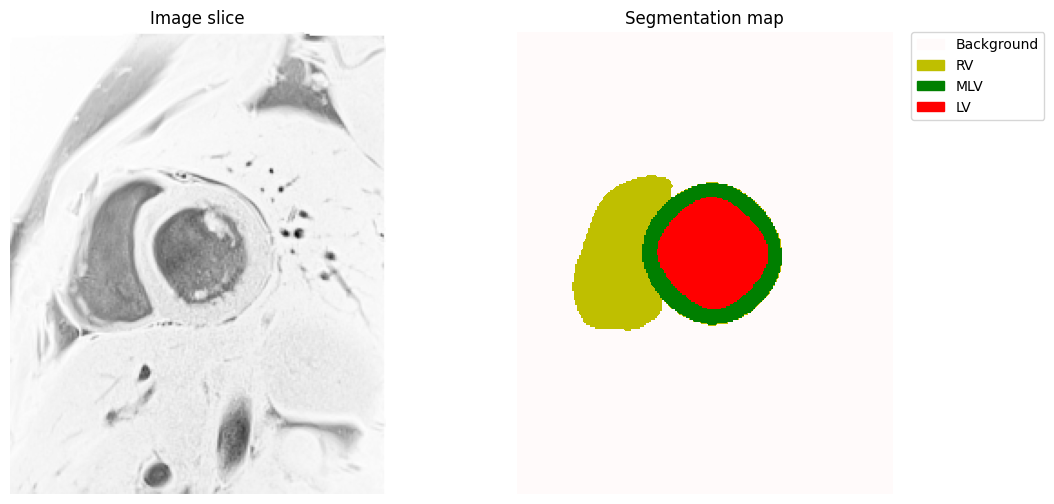

In [367]:
i = 5
case_no = 7
#my_cmap = ListedColormap(['grey', 'y','g','orange'])
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
ax1.imshow(SGD_model_A.get_input_image(case_no)[i, :, :], cmap = 'Greys')
ax1.set_title('Image slice')
im = ax2.imshow(SGD_model_A.get_gt(case_no)[i, :, :], cmap = my_cmap2)
ax2.set_title('Segmentation map')
ax1.axis('off')
ax2.axis('off')
# get the colors of the values, according to the 
# colormap used by imshow
values = np.unique(SGD_model_A.get_gt(case_no).ravel())
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
l = ["Background", "RV", "MLV", "LV"]
patches = [ mpatches.Patch(color=colors[i], label=l[i] ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.savefig("plots/example_image_segm")
plt.show()

# Plot accuracy cases

In [ ]:
SGD_model_A.files_pred_segm

In [338]:
# low accuracy
# loop over all predictions of best model

accuracy = []
for i in range(len(SGD_model_A.files_pred_segm)):

    gt = SGD_model_A.get_gt(i)
    best_model = SGD_model_A.get_best_model_segm(i)
    correct_labels = gt == best_model

    accuracy.append(correct_labels.sum()/(gt.size))
accuracy = np.array(accuracy) 

In [340]:
print("Best model predicitons")
res = sorted(range(len(accuracy)), key = lambda sub: accuracy[sub])
print("Bad case_no: ", res[:6])
print("Good case_no: ", res[-6:])

Best model predicitons
Bad case_no:  [38, 39, 19, 114, 244, 18]
Good case_no:  [256, 151, 46, 257, 14, 275]


In [342]:
dice_scores = []
for i in range(len(SGD_model_A.files_pred_segm)):

    gt = SGD_model_A.get_gt(i)
    best_model = SGD_model_A.get_best_model_segm(i)
    #orrect_labels = gt == best_model

    dice_scores.append(dice(gt, best_model))
dice_scores = np.array(dice_scores) 

In [343]:
print("Best model predicitons, dice")
res = sorted(range(len(dice_scores)), key = lambda sub: dice_scores[sub])
print("Bad case_no: ", res[:6])
print("Good case_no: ", res[-6:])

Best model predicitons, dice
Bad case_no:  [39, 60, 38, 244, 245, 59]
Good case_no:  [177, 103, 199, 150, 67, 175]


In [344]:
dice_scores = []
for i in range(len(SGD_model_A.files_pred_segm)):

    gt = SGD_model_A.get_gt(i)
    best_model = SGD_model_A.get_posterior_vector(i, multi_modal=True)
    #orrect_labels = gt == best_model

    dice_scores.append(dice(gt, best_model))
dice_scores = np.array(dice_scores) 
print("Multi modal predicitons, dice")
res = sorted(range(len(dice_scores)), key = lambda sub: dice_scores[sub])
print("Bad case_no: ", res[:6])
print("Good case_no: ", res[-6:])

Multi modal predicitons, dice
Bad case_no:  [275, 14, 282, 257, 111, 224]
Good case_no:  [28, 246, 284, 6, 19, 18]


In [405]:
case_no = 256
input_image = SGD_model_A.get_input_image(case_no)
test_gt = SGD_model_A.get_gt(case_no)
test_best_model = SGD_model_A.get_best_model_segm(case_no)
ensemble_segmentation = SGD_model_A.get_ensemble_segmentation(case_no)
posterior_entropy = SGD_model_A.get_posterior_entropy(case_no)
best_model_entropy = SGD_model_A.get_best_model_entropy(case_no)



Plot of slice no:  4



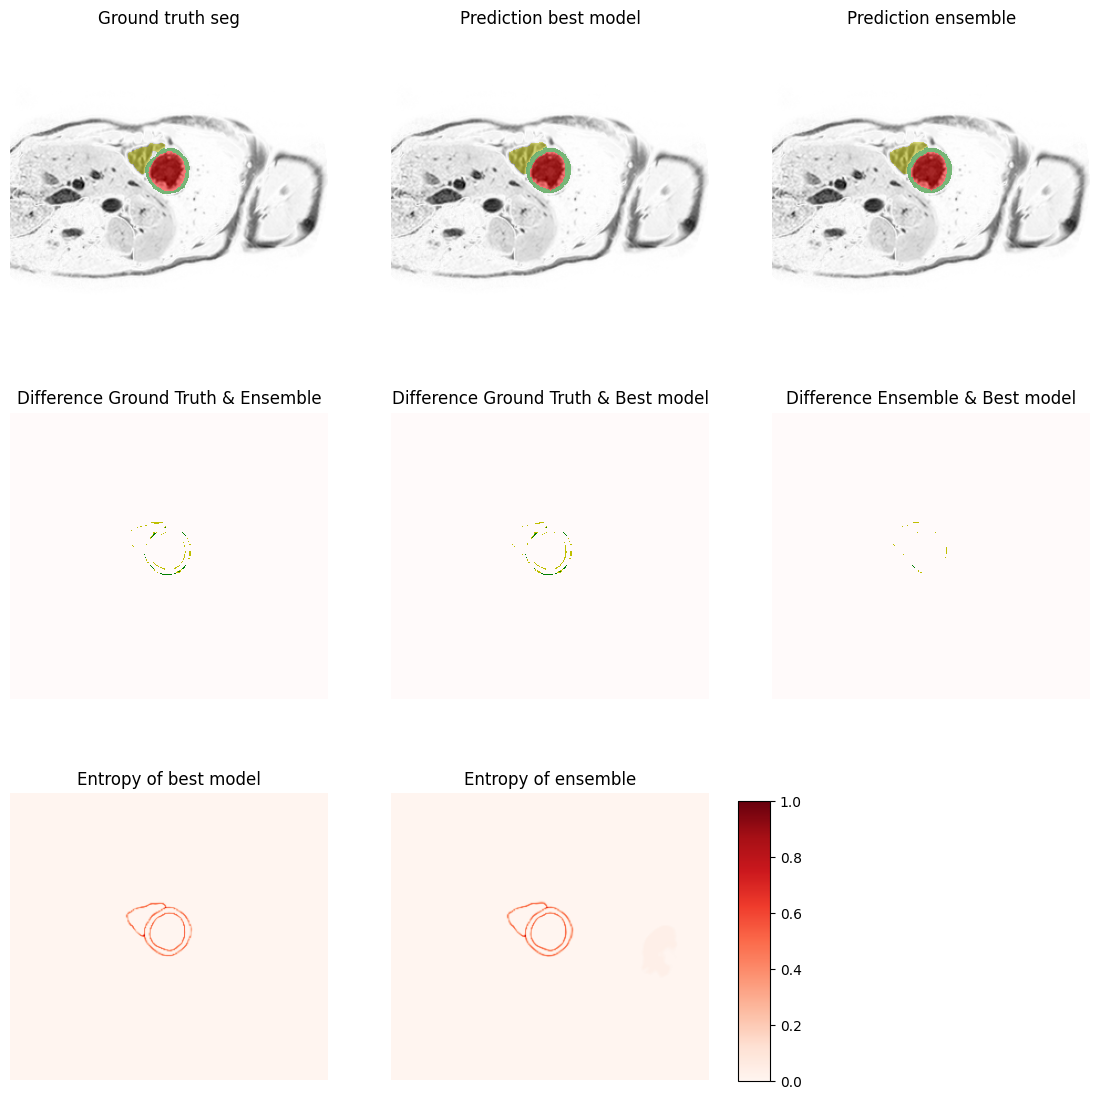

In [406]:
i = 4

print("Plot of slice no: ", i)
print()
alpha = 0.3
fig, ax = plt.subplots(3,3, figsize = (16, 14))
my_cmap = ListedColormap(['y','g','r'])
my_cmap2 = ListedColormap(['snow', 'y','g','r'])
#my_cmap.set_under('w', alpha=0)

#ax[0,0].imshow(input_image[i, :, :], cmap='Greys') 
#ax[0,0].set_title('Input image')

ax[0,0].imshow(input_image[i, :, :], cmap='Greys')
masked = np.ma.masked_where(test_gt[i, :, :] == 0, test_gt[i, :, :])
ax[0,0].imshow(masked, vmin=0, vmax=3, alpha = 0.5, cmap = my_cmap2) 
ax[0,0].set_title('Ground truth seg')
#rect = patches.Rectangle((35, 87), 89, 86, linewidth=1, edgecolor='r', facecolor='none')
#ax[0,1].add_patch(rect)

ax[0,1].imshow(input_image[i, :, :], cmap='Greys')
masked = np.ma.masked_where(test_best_model[i, :, :] == 0, test_best_model[i, :, :])
ax[0,1].imshow(masked, alpha = 0.5, cmap = my_cmap)
ax[0,1].set_title('Prediction best model')

ax[0,2].imshow(input_image[i, :, :], cmap='Greys')
#ax[0,3].imshow(test_gt[i, :, :], cmap = my_cmap, alpha = 0.7)#vmin=0, vmax=3
masked = np.ma.masked_where(ensemble_segmentation[i, :, :] == 0, ensemble_segmentation[i, :, :])
ax[0,2].imshow(masked, interpolation = None, alpha = 0.5, cmap = my_cmap)#vmin=0, vmax=3
ax[0,2].set_title('Prediction ensemble')

ax[1,0].imshow(np.abs(ensemble_segmentation[i, :, :]- test_gt[i, :, :]), vmin=0, vmax=3, cmap = my_cmap2)
ax[1,0].set_title('Difference Ground Truth & Ensemble')
ax[1,1].imshow(np.abs(test_gt[i, :, :]- test_best_model[i, :, :]), vmin=0, vmax=3, cmap = my_cmap2)
ax[1,1].set_title('Difference Ground Truth & Best model')
ax[1,2].imshow(np.abs(ensemble_segmentation[i, :, :]- test_best_model[i, :, :]), vmin=0, vmax=3, cmap = my_cmap2)
ax[1,2].set_title('Difference Ensemble & Best model')
entropy_plot = ax[2,1].imshow(posterior_entropy[i, :, :], vmin=0, vmax=1, cmap='Reds')#posterior_entropy

ax[2,1].set_title('Entropy of ensemble')

entropy_plot2 = ax[2,0].imshow(best_model_entropy[i, :, :], vmin=0, vmax=1, cmap='Reds')#posterior_entropy
#fig.colorbar(entropy_plot2)
ax[2,0].set_title('Entropy of best model')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.58, 0.12, 0.02, 0.2])
fig.colorbar(entropy_plot, cax=cbar_ax)

[axi.set_axis_off() for axi in ax.ravel()]
plt.savefig('plots/plot_of_good_best_model_accuracy'+str(case_no))
plt.show()

In [358]:
SGD_model_A.get_dice_one_case(SGD_model_A.get_best_model_segm, case_no)

[0.0, 0.5445389435989257, 0.8002722676001556]
